# Adaptive Climate System

A simplified 0-D, time-varying model of the Earth's energy balance:

$$\rho c_p H \frac{dT}{dt} = R -  bT$$

- $T$ is the global average surface temperature (relative to pre-industrial) [$C$]
- $b$ is the climate sensitivity parameter [$^{\circ} C$]
- $H$ is the ocean mixed layer depth [$m$]
- $R$ is radiative forcing [$Wm^{-2}$]
- $\rho$ is the density of sea water [$kgm^{-3}$]
- $c_p$ is the specific heat capacity of seawater [$Jkg^{-1} C^{-1}$]

The simple climate model is an energy balance model that accounts for feedbacks, natural variability, and an ocean to help simulate the main components that determine changes in global mean temperature.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot options
plt.rcParams["figure.autolayout"] = True
plt.style.use('seaborn')


In [11]:
class ClimateSystem:
    def __init__(self):
        """
        Initialize constants and parameters
        """
        # climate sensitivity
        # this should depend on a climate sensitivity model
        self.b = 2.35

        # ocean mixed layer depth (kg/m^3)
        self.H = 100

        # radiative forcing (W/m^2)
        self.R = 0.5

        # density of sea water (kg/m^3)
        self.rho = 1025

        # heat capacity of sea water (J/kg/K)
        self.c_p = 3985

        # change in time (s), this is the value for a year in seconds
        self.delta_t = 365.25*24*60*60  # seconds

        # this is the benchmark temperature for the model,
        # if predicted temp is higher than this, the model fitness at that time is lower
        # if predicted temp is lower than this, the model fitness at that time is higher
        self.bench_temp = 2

        self.accepable_temp_increase = 0.5

        self.start = 14  # start from this year, 2021

        # forcing types
        self.forcing_types = ['Forcing RCP26 [W/m2]', 'Forcing RCP45 [W/m2]',
                              'Forcing RCP6 [W/m2]', 'Forcing RCP85 [W/m2]']

        # dependent on RCP i.e forcing type
        self.avg_increase_rel_to_1986_2005 = {
            'Forcing RCP26 [W/m2]': 1.0, 'Forcing RCP45 [W/m2]': 1.8, 'Forcing RCP6 [W/m2]': 2.2, 'Forcing RCP85 [W/m2]': 3.7}

        # this is used across the model, can be changed
        self.selected_forcing_type = self.forcing_types[0]

        self.predicted_temps_by_projected_forcings = []

        # get data
        data_and_projections = self.get_data()
        self.data = data_and_projections[0]
        self.projections = data_and_projections[1]

    def get_data(self):
        """
        Reads in data from a csv file and returns a pandas dataframe
        """

        data = pd.read_csv('data/climate_forcing_1880-2006.csv')
        projections = pd.read_csv('data/climate_forcing_projected.csv')
        return data, projections

    def get_forcing(self, key):
        """
        Returns the radiative forcing for a given key
        """
        return self.data['Year'], self.data[key]

    def get_total_forcing(self):
        """
        Returns the total radiative forcing
        """
        return self.data['Year'], self.data['Total radiative forcing [W/m2]']

    def get_forcing_projections(self, key=None):
        """
        Returns the radiative forcing for a given scenario
        """
        if key is None:
            key = self.selected_forcing_type
        return self.projections['Year'], self.projections[key]

    def get_observed_temp(self):
        """
        Returns the observed temperature
        """
        return self.data['Year'], self.data['Observed Temperature [C]']

    def get_p_max(self, start_from=15):
        """
        Returns the maximum possible radiative forcing in forcing type
        """
        _, data = self.get_forcing_projections(
            self.selected_forcing_type)

        return max(data[start_from:])

    def predict_temp(self, forcings, b=None, H=None):
        """
        Returns the predicted temperature for a given set of forcings
        over a time series.

        The model equation is stepped forward in time using Euler's method.
        """
        steps = len(forcings)

        b = b if b else self.b
        H = H if H else self.H

        # initialize temperature array
        temps = np.zeros(steps)

        # loop through time steps and solve model equation
        for i in range(steps-1):
            dTdt = (forcings[i]-b*temps[i])/(self.rho*self.c_p*H)
            temps[i+1] = temps[i]+dTdt*self.delta_t

        return temps

    def plot_temps_by_forcings(self, forcing_types, b=None, H=None):
        """
        Plots the predicted temperature against the radiative forcing(s) given
        """
        _, ax = plt.subplots(nrows=1, ncols=len(
            forcing_types), figsize=(20, 5))
        estimated_climate_sensitivity = b if b else self.b
        ocean_mixed_layer_depth = H if H else self.H

        for i in range(len(forcing_types)):
            year, data = self.get_forcing_projections(forcing_types[i])
            self.predicted_temps_by_projected_forcings.append(self.predict_temp(
                data, estimated_climate_sensitivity, ocean_mixed_layer_depth))

            ax[i].plot(
                year, self.predicted_temps_by_projected_forcings[i], '-', label='Predicted')
            ax[i].set_xlabel('Year')
            ax[i].set_ylabel('[$^{\circ}C$]')
            ax[i].axhline(y=self.avg_increase_rel_to_1986_2005[forcing_types[i]], color='grey', linestyle='--',
                          label="Avg increase (1986 - 2100): " + str(self.avg_increase_rel_to_1986_2005[forcing_types[i]]) + "$^\circ C$")
            ax[i].axhline(y=2, color='r', linestyle='--',
                          label='Limit [2$^{\circ}$C]')
            ax[i].axvline(x=2100, color='r', linestyle='--', label='Year 2100')
            ax[i].set_title(
                'Predicted temperature for ' + forcing_types[i])
            ax[i].set_ylim(0, 5)
            ax[i].legend()

        print("estimated climate sensitivity, b:",
              estimated_climate_sensitivity)
        print("ocean mixed layer depth, H: ", ocean_mixed_layer_depth)

    def get_forcing_growth_rate(self, forcings, start=0, stop=-1):
        """
        Returns the growth rate of the radiative forcing, a single value
        """
        forcings = np.array(forcings)

        growth_rate = (forcings[stop]-forcings[start])/forcings[start]
        return growth_rate

    def estimate_climate_sensitivity(self, fixed: bool = False):
        """
        The given estimate of climate sensitivity by IPCC is 1.5[deg C] - 4.5[deg C],
        and is fairly close to 3[deg C] average across different studies with some reporting very-high or very-low sensitivity.

        This function returns a value from the a uniform distribution between the two extremes.
        """
        # seed random number generator
        if fixed:
            np.random.seed(1)
        return np.random.uniform(1.5, 4.5)

    def logistic_map(self, r, x):
        """
        Returns the next value of the logistic map
        Behavior of the logisic function: https://en.wikipedia.org/wiki/Logistic_map
        """
        return r*x*(1-x)

    def generate_forcing_space(self, r, p_initial, p_max, steps=100):
        """
        Returns a list of values of the logistic map
        """
        x = p_initial/p_max
        forcing_space = [x]
        for i in range(steps):
            x = self.logistic_map(r, x)
            forcing_space.append(x)
        return forcing_space

    def convert_to_forcing_value(self, x, p_max=None):
        """
        Converts a value of the logistic map to a forcing value
        """
        p_max = p_max if p_max else self.get_p_max()
        return x*p_max

    def tune_r(self, r, x_n, index):
        """
        Depending on fitness, the value of r is adjusted.
        Initial value of r should be 4 for SDIC (Sensitivity Dependence on Initial Condition)
        """
        p_max = self.get_p_max()
        forcing = self.convert_to_forcing_value(x_n, p_max)

        # get forcing at index
        _, forcings = self.get_forcing_projections(
            self.selected_forcing_type)

        forcings = [forcings[index], forcing]

        _, distance = self.fitness(forcings)

        # if distance is 50% or more away from the benchmark temperature,
        # the r value is adjusted

        print(distance)

        if distance > 0.5 <= 4:
            return r*1.1
        elif distance < 0.5:
            return r*0.9
        elif distance < 0:
            return r
        else:
            return 4

    def fitness(self, forcings):
        """
        Returns the fitness of the best_forcing_value.
        """
        predicted_temps = self.predict_temp(forcings, self.b, self.H)

        # compare f + 1 to f
        results = [predicted_temps[i] - predicted_temps[i+1]
                   for i in range(0, len(predicted_temps)-1)]
        results.insert(0, 0)

        # create an array of len predicted_temps containing self.benchmark_temp
        # benchmark_temps = np.full(len(predicted_temps), self.bench_temp)

        # distances = predicted_temps - benchmark_temps

        return results

    def generate_forcing(self, r, p_initial, p_max, steps=100, forcing_type=None):
        """
        Returns the best value of the logistic map or for a given forcing type
        """
        if forcing_type:
            _, forcings = self.get_forcing(forcing_type)
            forcing_space = forcings
        else:
            forcing_space = self.generate_forcing_space(
                r, p_initial, p_max, steps)

        best_forcing_value = np.min(forcing_space)
        best_forcing_index = np.argmin(forcing_space)

        print("before conversion", best_forcing_value)

        best_forcing_value = self.convert_to_forcing_value(
            best_forcing_value, p_max)

        print("after conversion", best_forcing_value)

        predicted_temp, fitness, performance = self.fitness(best_forcing_value)

        return best_forcing_value, predicted_temp, fitness, performance

    def adapt(self, x_initial, r_initial=4, iter=20, n_years=100):
        """
        Adapts the value of r to the best forcing value given T

        - if higher than previous [decay]
        - if eqaul to previous (i.e equal to zero)
            - if in acceptable region [stabilize]
            - else [chaos]
        - if lesser than previous continue [no change]
        """
        r_space = np.full(n_years, np.random.uniform(3.54409, r_initial))
        x_n = [x_initial]
        current_forcings = []

        # Baseline forcing accepteable
        years, forcings = self.get_forcing_projections(self.forcing_types[0])
        acceptable_mean_distance = np.mean(forcings)

        for i in range(iter):
            # init chaos values
            for i in range(0, n_years):
                value = self.logistic_map(r_space[i], x_n[i])
                x_n.append(value)

            # convert to forcing values
            current_forcings = [self.convert_to_forcing_value(x) for x in x_n]

            # get distances
            distances = self.fitness(current_forcings)
            r_update = r_space.copy()

            # np.random.seed(1)

            for index in range(1, len(distances)-1):
                if distances[index] > distances[index - 1]:
                    # decay
                    r_update[index] = np.random.uniform(0.5, 1)
                elif distances[index] < distances[index - 1]:
                    # stabilize
                    r_update[index] = np.random.uniform(1.5, 1.65)
                elif distances[index] == distances[index - 1]:
                    # get forcing and prediction at index
                    forcing_i = current_forcings[index]
                    predict_temp_i = self.predict_temp(
                        [forcing_i], self.b, self.H)[0]

                    if predict_temp_i <= self.accepable_temp_increase:
                        # stabilize
                        r_update[index] = np.random.uniform(1.5, 1.65)
                    else:
                        # chaos
                        r_update[index] = np.random.uniform(3.54409, 4)

            r_space = r_update.copy()

            # reset x_n
            x_n = [x_initial]

        return r_space


# Initialize the model
climate = ClimateSystem()


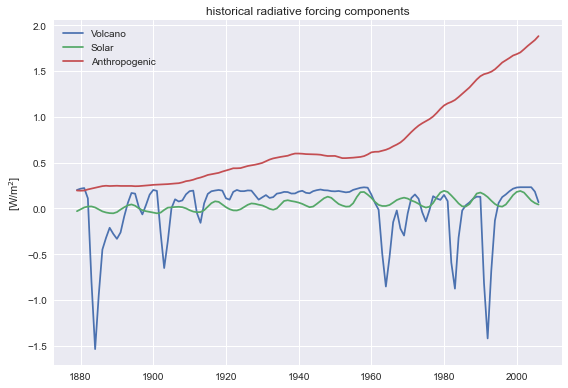

In [12]:
plt.figure()
plt.plot(*climate.get_forcing('Volcano [W/m2]'), label='Volcano')
plt.plot(*climate.get_forcing('Solar [W/m2]'), label='Solar')
plt.plot(*climate.get_forcing('Anthropogenic [W/m2]'), label='Anthropogenic')
plt.ylabel('[W/m$^2$]')
plt.title('historical radiative forcing components')
plt.legend()


## Anthropogenic effect

"Representative Concentration Pathways (RCPs) are not new, fully integrated scenarios (i.e., they are not a complete package of socioeconomic, emissions and climate projections). They are consistent sets of projections of only the components of radiative forcing that are meant to serve as input for climate modeling, pattern scaling and atmospheric chemistry modeling," according to the RCP Database.

This is the parameter we are investigating and eventually going to adapt.

### Historical Data

Let's see how much human forcing we have in the dataset


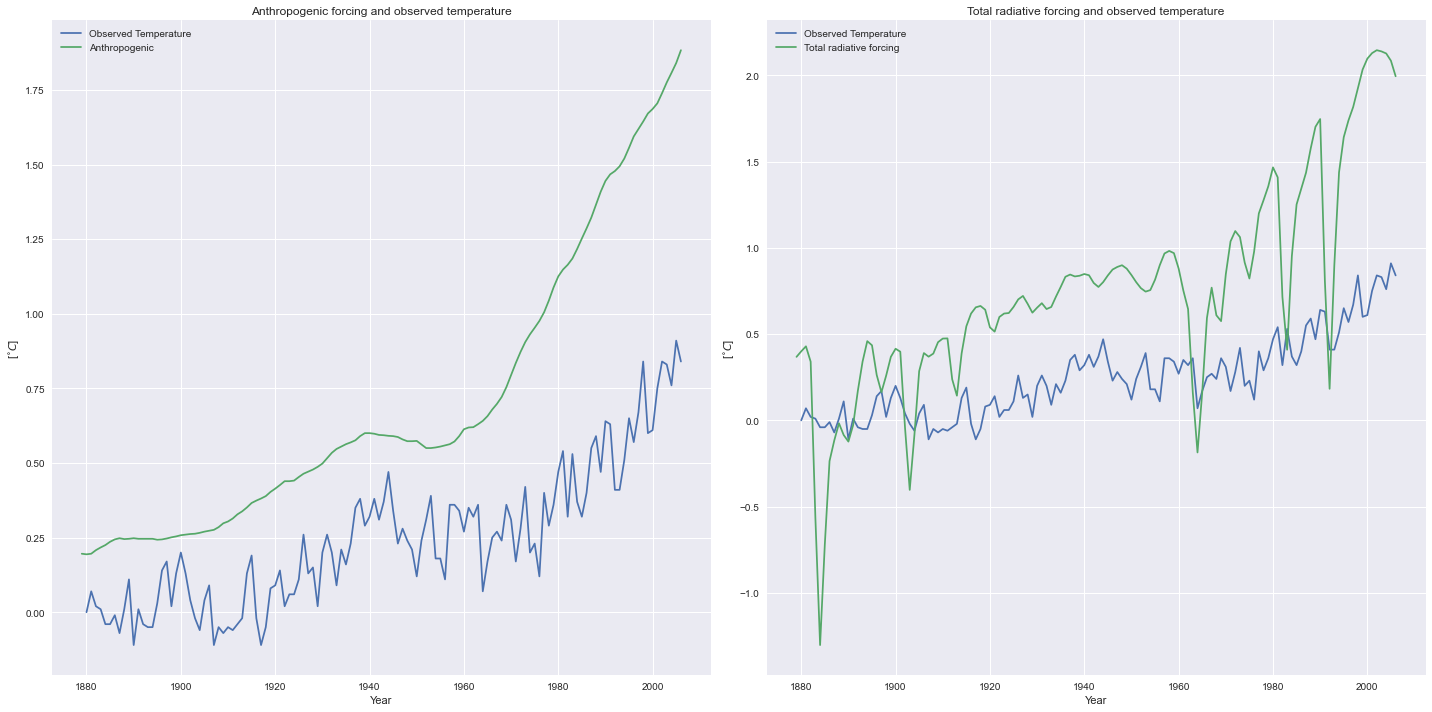

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].plot(*climate.get_observed_temp(), label='Observed Temperature')
ax[0].plot(*climate.get_forcing('Anthropogenic [W/m2]'), label='Anthropogenic')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('[$^{\circ}C$]')
ax[0].set_title('Anthropogenic forcing and observed temperature')
ax[0].legend()

ax[1].plot(*climate.get_observed_temp(), label='Observed Temperature')
ax[1].plot(*climate.get_total_forcing(), label='Total radiative forcing')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('[$^{\circ}C$]')
ax[1].set_title('Total radiative forcing and observed temperature')
ax[1].legend()


### Projections


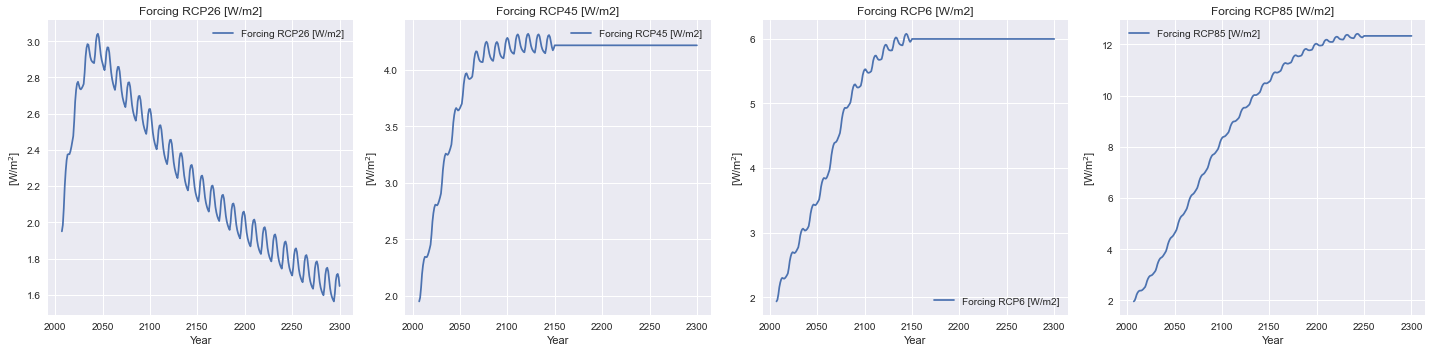

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))

for i in range(len(climate.forcing_types)):
    ax[i].plot(*climate.get_forcing_projections(climate.forcing_types[i]), label=climate.forcing_types[i])
    ax[i].set_xlabel('Year')
    ax[i].set_ylabel('[W/m$^2$]')
    ax[i].set_title(climate.forcing_types[i])
    ax[i].legend()


# Predicted temperatures based on RCPs

estimated climate sensitivity, b: 2.35
ocean mixed layer depth, H:  100


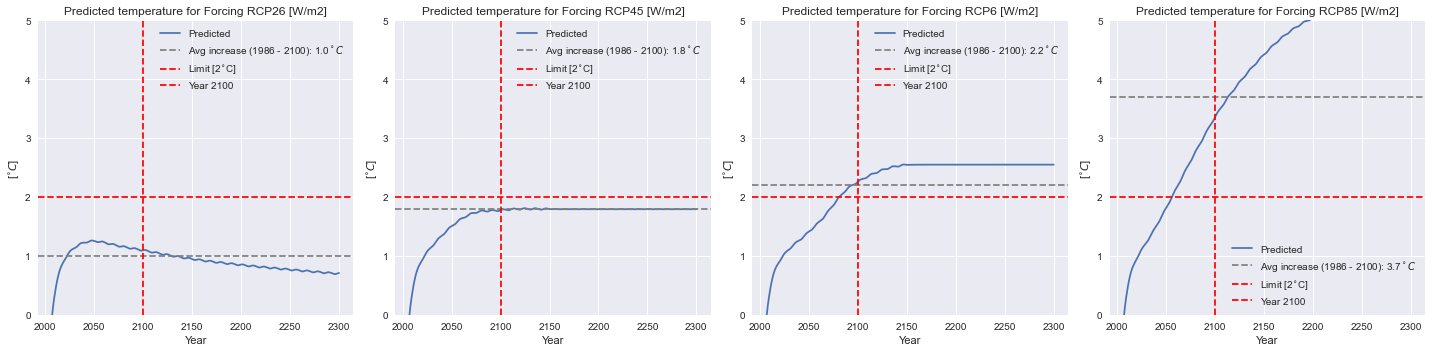

In [15]:
climate.plot_temps_by_forcings(climate.forcing_types)

# Using a chaotic regime to generate projections

Using the logistic map


0.18247704944435497


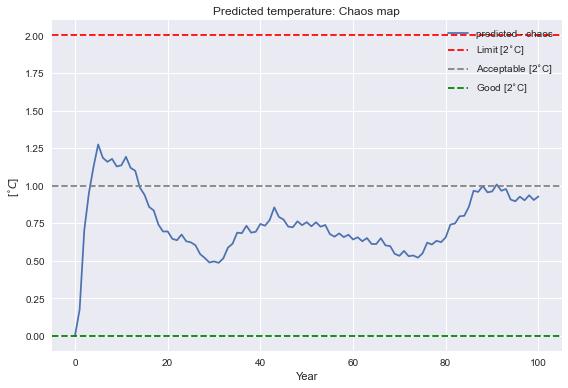

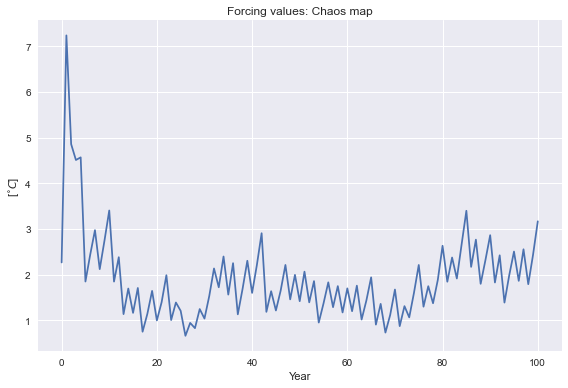

In [16]:
# Select the forcing type
climate.selected_forcing_type = climate.forcing_types[3]

x = 2.266/climate.get_p_max()

test = climate.adapt(x, 4, iter=1)
print(x)

# get x using the values of test
x_n = [x]
for i in range(0, len(test)):
    value = climate.logistic_map(test[i], x_n[i])
    x_n.append(value)

forcings = [climate.convert_to_forcing_value(x) for x in x_n]

# _, forcings_accp = climate.get_forcing_projections(climate.forcing_types[0])

plt.plot(climate.predict_temp(forcings), label="predicted - chaos") 
# plt.plot(climate.predict_temp(forcings_accp), label="predicted - " + climate.forcing_types[0]) 
plt.title("Predicted temperature: Chaos map") 
plt.xlabel("Year")
plt.ylabel("[$^{\circ}C$]")
plt.axhline(y=2, color='r', linestyle='--',
                          label='Limit [2$^{\circ}$C]')
plt.axhline(y=1, color='gray', linestyle='--',
                          label='Acceptable [2$^{\circ}$C]')
plt.axhline(y=0, color='g', linestyle='--',
                          label='Good [2$^{\circ}$C]')
plt.legend()

plt.figure()
plt.title("Forcing values: Chaos map") 
plt.xlabel("Year")
plt.ylabel("[$^{\circ}C$]")
plt.plot(forcings)